In [31]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

import pickle

from tqdm import tqdm
import os

# Preprocceing

In [32]:
df = pd.read_csv('kognoz2.csv')
df.head(5)

,Unnamed: 0,Unnamed: 0.1,title,link,description,pubDate,articleid,website,issue,type,showcase
0,0,0,No Duty on Chinese Imports for Public Solar Po...,http://myimpact.in/index.php?page=Clipj&id=00e...,New Delhi Chinese imports for public solar po...,2020-07-01,003bd7b1-bb3f-11ea-87c0-70f3955ff93a,The Economic Times - Delhi,Power Industry News,print,NO
1,1,1,Solar Tariffs Fall to Record Low of Rs 2.36/Unit,http://myimpact.in/index.php?page=Clipj&id=fe5...,Bengaluru: Solar tariffs fell to a record low...,2020-07-01,0486da8f-bb41-11ea-b40c-0068ebdc2fd0,The Economic Times - Mumbai,General Industry news,print,NO
2,2,2,Corning appoints new MD for India,http://myimpact.in/index.php?page=Clipj&id=234...,Corning Incorporated has announced that Sudhi...,2020-07-01,3497c933-bb95-11ea-9c46-,BioSpectrum - National,General Industry news,print,NO
3,3,3,L&T Makes Key Component for Advanced Nuclear R...,http://myimpact.in/index.php?page=Clipj&id=490...,MUMBAI Larsen & Toubro has completed the manu...,2020-07-01,3aa7ae60-bb3f-11ea-87c0-70f3955ff93a,The Economic Times - Delhi,General Industry news,print,NO
4,4,4,Two percent discount on lump sum payment of el...,http://myimpact.in/index.php?page=Clipj&id=566...,NaN,2020-07-01,41b5248a-bb4f-11ea-a37a-0068ebdd9697,Saamna - Mumbai,Power Industry News,print,NO


In [33]:
df['issue'].value_counts()

0                        149
Power Industry News      121
General Industry news    115
Electric Vehicles         70
Niti Aayog                45
Name: issue, dtype: int64

In [34]:
df['issue'] = df['issue'].replace(["Customers News"],"0")
df['issue'] = df['issue'].replace(["Power Industry News"],"1")
df['issue'] = df['issue'].replace(["General Industry news"],"2")
df['issue'] = df['issue'].replace(["Electric Vehicles"],"3")
df['issue'] = df['issue'].replace(["Niti Aayog  "],"4")

In [35]:
final = df

In [36]:
sent_0 = final['description'].values[245]
print(sent_0)

 Yost cited a 2019 study that GM's Lordstown closure resulted in the loss of nearly 8,000 jobs and more than $8 billion in local economic activity, while the local school district had relied on the plant for 10% of its budget.<p> GM said Tuesday it "has demonstrated its commitment to Ohio through our investments of more than $3.3 billion in Ohio since 2009 ... We look forward to continuing our dialogue with the state."</p><p> As recently as 2016, GM employed 4,500 people at Lordstown and cut the final 1,500 jobs when production of the slow-selling Chevrolet Cruze ended.</p><p> GM sold the plant to an electric vehicle startup Lordstown Motors that hopes to begin production next year with a few hundred workers.</p><p> GM and LG Chem are investing $2.2 billion to build a battery cell manufacturing plant in Lordstown that will create 1,100 jobs.</p><p> Ohio Governor Mike DeWine told reporters last week the state does not "necessarily have to get that cash back but what we do want to see is

In [37]:
final['description']=final['description'].apply(str)

In [38]:
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [39]:
stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])


In [40]:
from bs4 import BeautifulSoup
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['description'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:02<00:00, 170.87it/s]


In [41]:
preprocessed_reviews[245]

'yost cited study gm lordstown closure resulted loss nearly jobs billion local economic activity local school district relied plant budget gm said tuesday demonstrated commitment ohio investments billion ohio since look forward continuing dialogue state recently gm employed people lordstown cut final jobs production slow selling chevrolet cruze ended gm sold plant electric vehicle startup lordstown motors hopes begin production next year hundred workers gm lg chem investing billion build battery cell manufacturing plant lordstown create jobs ohio governor mike dewine told reporters last week state not necessarily get cash back want see things promote jobs ohio not actively pursuing clawback also read u appeals court stays order requiring gm fca meet resolve gm lawsuit'

In [42]:
final['Cleaned_Text'] = preprocessed_reviews

In [43]:
x = final['Cleaned_Text']
x.size

500

In [44]:
y = final['issue']
y.size

500

In [45]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=42)

# LR using BOW

In [46]:
count_vect = CountVectorizer()
bow_X_train = count_vect.fit_transform(x_train)
bow_X_test = count_vect.transform(x_test)

In [47]:
#Grid search & L2

In [48]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

lam = [0.001,0.01,0.1,1,10]
clf = LogisticRegression()
param_grid = {'C':lam}
grid = GridSearchCV(estimator = clf,param_grid=param_grid ,cv = 5,n_jobs = 3)
grid.fit(bow_X_train, y_train)
print("best C = ", grid.best_params_)
print("Accuracy on train data = ", grid.best_score_*100)
a = grid.best_params_
optimal_a1 = a.get('C')

best C =  {'C': 0.01}
Accuracy on train data =  78.57142857142857


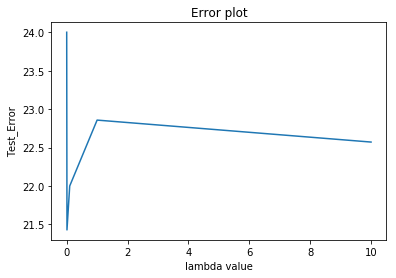

In [49]:
import matplotlib.pyplot as plt 

error = [(1-i)*100 for i in grid.cv_results_['mean_test_score']]
plt.plot(lam, error)
plt.title('Error plot')
plt.xlabel('lambda value')
plt.ylabel('Test_Error')
plt.show()

In [50]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix


clf = LogisticRegression(C = optimal_a1)

clf.fit(bow_X_train,y_train)

pred = clf.predict(bow_X_test)

acc1 = accuracy_score(y_test, pred) * 100
pre1 = precision_score(y_test, pred, average = None) * 100
rec1 = recall_score(y_test, pred, average = None) * 100
f11 = f1_score(y_test, pred, average = None) * 100

print("accuracy = ",acc1)
print("precision =",pre1)
print("recall = ", rec1)
print("F1-Score = ",f11)

accuracy =  80.0
precision = [80.76923077 92.30769231 63.63636364 94.44444444 90.        ]
recall =  [89.36170213 63.15789474 75.67567568 94.44444444 90.        ]
F1-Score =  [84.84848485 75.         69.13580247 94.44444444 90.        ]


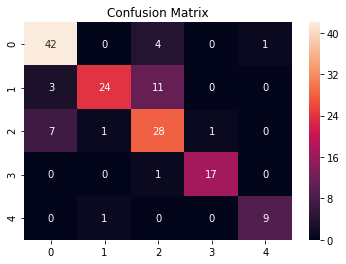

In [51]:

import seaborn as sns
cm = confusion_matrix(y_test,pred)
sns.heatmap(cm, annot=True,fmt='d')
plt.title('Confusion Matrix')
plt.show()

In [52]:
#Grid and L1

In [53]:
clf = LogisticRegression(C = optimal_a1, penalty='l1')

clf.fit(bow_X_train,y_train)

pred = clf.predict(bow_X_test)

acc2 = accuracy_score(y_test, pred) * 100
pre2 = precision_score(y_test, pred, average = None) * 100
rec2 = recall_score(y_test, pred, average = None) * 100
f12 = f1_score(y_test, pred, average = None) * 100

print("accuracy = ",acc2)
print("precision =",pre2)
print("recall = ", rec2)
print("F1-Score = ",f12)

accuracy =  39.33333333333333
precision = [41.33333333 46.15384615 30.95238095 75.         37.5       ]
recall =  [65.95744681 15.78947368 35.13513514 16.66666667 60.        ]
F1-Score =  [50.81967213 23.52941176 32.91139241 27.27272727 46.15384615]


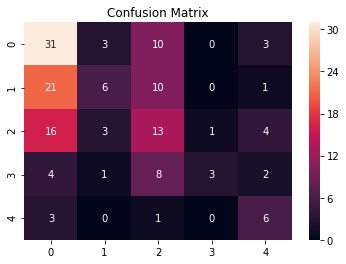

In [54]:
import seaborn as sns
cm = confusion_matrix(y_test,pred)
sns.heatmap(cm, annot=True,fmt='d')
plt.title('Confusion Matrix')
plt.show()

In [55]:
from prettytable import PrettyTable

x = PrettyTable()

reg1 = 'L2'
reg2 = 'L1'
cv = 'Grid'
x.field_names = ["CV","Regularizer","C","Test_Acc(%)","Test_Error(%)"]

acc1 = np.around(acc1, decimals = 2)
err1 = np.around(100-acc1, decimals = 2) 

acc2 = np.around(acc2, decimals = 2)
err2 = np.around(100-acc2, decimals = 2) 

x.add_row([cv,reg1,optimal_a1,acc1,err1])
x.add_row([cv,reg2,optimal_a1,acc2,err2])

print(x)

+------+-------------+------+-------------+---------------+
|  CV  | Regularizer |  C   | Test_Acc(%) | Test_Error(%) |
+------+-------------+------+-------------+---------------+
| Grid |      L2     | 0.01 |     80.0    |      20.0     |
| Grid |      L1     | 0.01 |    39.33    |     60.67     |
+------+-------------+------+-------------+---------------+


# Randome search L2

In [57]:
from scipy.stats import uniform
clf = LogisticRegression()
param_grid = { 'C':uniform()}
grid = RandomizedSearchCV(estimator = clf,param_distributions=param_grid ,cv = 5,n_jobs = 3)
grid.fit(bow_X_train, y_train)
print("best C = ", grid.best_params_)
print("Accuracy on train data = ", grid.best_score_*100)
a = grid.best_params_
optimal_a1 = a.get('C')

best C =  {'C': 0.03572593120871259}
Accuracy on train data =  79.42857142857143


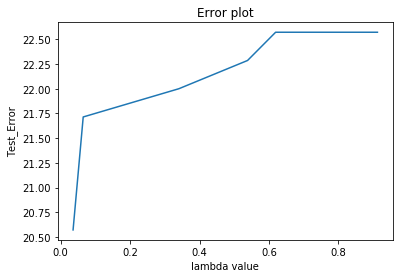

In [58]:
lam =[]
for i in range(10):
    lam.append(grid.cv_results_['params'][i]['C'])
ind = np.argsort(lam)
error = [(1-i)*100 for i in grid.cv_results_['mean_test_score']]
l_values=[]
err=[]
for i in ind:
    l_values.append(lam[i])
    err.append(error[i])
plt.plot(l_values, err)
plt.title('Error plot')
plt.xlabel('lambda value')
plt.ylabel('Test_Error')
plt.show()

In [59]:
clf = LogisticRegression(C = optimal_a1)

clf.fit(bow_X_train,y_train)

pred = clf.predict(bow_X_test)

acc1 = accuracy_score(y_test, pred) * 100
pre1 = precision_score(y_test, pred, average = None) * 100
rec1 = recall_score(y_test, pred, average = None) * 100
f11 = f1_score(y_test, pred, average = None) * 100

print("accuracy = ",acc1)
print("precision =",pre1)
print("recall = ", rec1)
print("F1-Score = ",f11)

accuracy =  79.33333333333333
precision = [76.92307692 96.15384615 62.79069767 94.44444444 90.90909091]
recall =  [ 85.10638298  65.78947368  72.97297297  94.44444444 100.        ]
F1-Score =  [80.80808081 78.125      67.5        94.44444444 95.23809524]


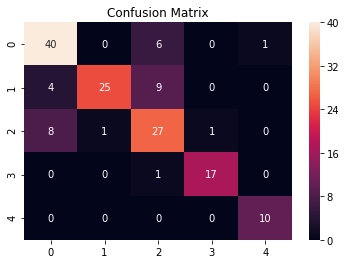

In [60]:
cm = confusion_matrix(y_test,pred)
sns.heatmap(cm, annot=True,fmt='d')
plt.title('Confusion Matrix')
plt.show()

In [61]:
#Randome search L1

In [62]:
clf = LogisticRegression(C = optimal_a1, penalty='l1')

clf.fit(bow_X_train,y_train)

pred = clf.predict(bow_X_test)

acc2 = accuracy_score(y_test, pred) * 100
pre2 = precision_score(y_test, pred, average = None) * 100
rec2 = recall_score(y_test, pred, average = None) * 100
f12 = f1_score(y_test, pred, average = None) * 100

print("accuracy = ",acc2)
print("precision =",pre2)
print("recall = ", rec2)
print("F1-Score = ",f12)

accuracy =  70.0
precision = [68.96551724 71.42857143 55.55555556 88.88888889 80.        ]
recall =  [85.10638298 78.94736842 40.54054054 88.88888889 40.        ]
F1-Score =  [76.19047619 75.         46.875      88.88888889 53.33333333]


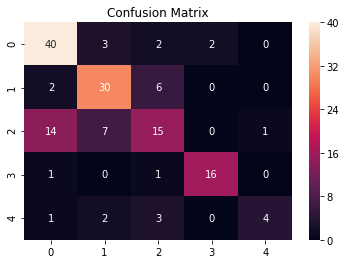

In [63]:
cm = confusion_matrix(y_test,pred)
sns.heatmap(cm, annot=True,fmt='d')
plt.title('Confusion Matrix')
plt.show()

In [64]:
x = PrettyTable()

reg1 = 'L2'
reg2 = 'L1'
cv = 'Randome'
x.field_names = ["CV","Regularizer","C","Test_Acc(%)","Test_Error(%)"]

acc1 = np.around(acc1, decimals = 2)
err1 = np.around(100-acc1, decimals = 2) 

acc2 = np.around(acc2, decimals = 2)
err2 = np.around(100-acc2, decimals = 2) 

x.add_row([cv,reg1,optimal_a1,acc1,err1])
x.add_row([cv,reg2,optimal_a1,acc2,err2])

print(x)

+---------+-------------+---------------------+-------------+---------------+
|    CV   | Regularizer |          C          | Test_Acc(%) | Test_Error(%) |
+---------+-------------+---------------------+-------------+---------------+
| Randome |      L2     | 0.03572593120871259 |    79.33    |     20.67     |
| Randome |      L1     | 0.03572593120871259 |     70.0    |      30.0     |
+---------+-------------+---------------------+-------------+---------------+
